# Veto Development Viewer

View ROOT files output from ALPACA in a conviniet way.
Contains functions to calculate difference, change scales, etc...

If you plan on using this as the basis of another viewer, copy section 1.1 (Plotting Functions).

For help, contact [Sam Eriksen](mailto:sam.eriksen@bristol.ac.uk)

## Plotting Functions

In [1]:
import ROOT
import copy 
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot

Welcome to JupyROOT 6.18/04


In [2]:
def get_hist(rfile, histname):
    hist = rfile.Get(histname)
    return copy.deepcopy(hist)

def get_keynames(self, dir=""):
    self.cd(dir)
    return [key.GetName() for key in ROOT.gDirectory.GetListOfKeys()]

def format_hist(hist, i):
    hist.SetMarkerStyle(7)
    hist.SetMarkerColor(colors[i] + 2)
    hist.SetLineColor(colors[i] + 2)
    hist.SetLineWidth(2)
    hist.SetMarkerColorAlpha(colors[i] + 2, 0.4)
    hist.GetXaxis().SetTitleOffset(1.5);
    hist.GetYaxis().SetTitleOffset(1.5);
    
def addHistogramToCanvas(canvas, stack, hist, **kwargs):
    
    print('to be made')
    

def fillCanvas(canvas, stack, fname, histName, i, j, norm, logs, scales, drawtype, haslegend, legendname, fitgauss, normconst):
    """Add a single histogram to the canvas
    """
    rfile = ROOT.TFile(fname)
    canvas.cd(i + 1)
    hist = get_hist(rfile, histName)
    try:
        if norm:
            nfactor = hist.Integral() / normconst # average seen by each PMT
            hist.Scale(1/nfactor)    
        if scales[0]:
            axis = hist.GetXaxis()
            axis.SetRangeUser(scales[0][0], scales[0][1])
        if scales[1]:
            axis = hist.GetYaxis()
            axis.SetRangeUser(scales[1][0], scales[1][1])
        if scales[2]:
            axis = hist.GetZaxis()
            axis.SetRangeUser(scales[2][0], scales[2][1])
        shortname = fname[fname.rfind('/')+1:fname.find('.')]
        histTitle = shortname + '/' + histName
        format_hist(hist, j)
        hist.SetTitle(histTitle)
        if logs[0]:
            canvas.cd(i+1).SetLogx()
        if logs[1]:
            canvas.cd(i+1).SetLogy()
        if logs[2]:
            canvas.cd(i+1).SetLogz()
        stack.Add(hist)   
        if fitgauss:
            hist.Fit('gaus', 'S')
        hist.Draw(drawtype + ' same')
        if haslegend:
            legend.AddEntry(hist,legendname,'l')
            legend.Draw('same')
        return canvas, stack
    except:
        print('Unable to add hist', histName, 'to canvas')
        return canvas, stack
    

def setupCanvas(fileWithHists, histList, 
                ncols=1, nOnCanvas =1,
                logs=[False,False,False], norm=False,
                scales=[[],[],[]], drawtype='colz',
                haslegend=False, legendname=None,
                infolevel='none', fitgauss=False,
                normconst = 1):
    """TODO: turn options into kwargs**
    TODO: turn into a class
    TODO: handle cases where fileWithHists is not a list and isn't same size as histList
    TODO: change so that histList is [[all hist1],[all hist2]] so can remove nOnCanvas and have multiples
    """
        
    nrows = int(math.ceil(((len(histList))/nOnCanvas)/ncols))
    canvas = ROOT.TCanvas("c","c",ncols*500, nrows*500)
    canvas.Divide(ncols,nrows)   
    stack = ROOT.THStack()
    legend.Clear()
    
    if infolevel == 'none':
        ROOT.gStyle.SetOptStat(000000)
    elif infolevel == 'all':
        ROOT.gStyle.SetOptStat(111111)
    
    for i in range(int(len(histList)/nOnCanvas)):
        legend.Clear()
        for j in range(nOnCanvas):
            thisfile = fileWithHists[j::nOnCanvas][i]
            thishist = histList[j::nOnCanvas][i]
            if legendname is None:
                lname = thishist[(thishist.rfind('/'))::]
            else:
                lname = legendname[j::nOnCanvas][i]
            canvas, stack = fillCanvas(canvas, stack, 
                                       thisfile, thishist,
                                       i, j, norm, logs, scales,
                                       drawtype, haslegend, lname,
                                       fitgauss, normconst)
        
    return canvas

def histDifference(file1, file2, histname1, histname2, norm=False, diffType='diff', normfactor=1, dim='1D', scales=[[],[],[]], logs=[False,False,False]):
    """Calculate the difference between two histograms.
    """
    
    canvas = ROOT.TCanvas("c","c",1000, 500)
    canvas.Divide(1,1)
    canvas.cd(1)
    stack = ROOT.THStack()
    
    rfile = ROOT.TFile(file1); hist1 = get_hist(rfile, histname1)
    rfile = ROOT.TFile(file2); hist2 = get_hist(rfile, histname2)

    nx = hist1.GetXaxis().GetNbins()
    
    if dim != '1D':
        ny = hist1.GetYaxis().GetNbins()
    
    pmtaverage1 = hist1.Integral() / normfactor
    pmtaverage2 = hist2.Integral() / normfactor
    
    
    if dim == '1D':
        for i in np.arange(1, nx+1):
            if diffType == 'diff':
                if norm:
                    diff = hist1.GetBinContent(int(i)) / pmtaverage1 - hist2.GetBinContent(int(i)) / pmtaverage2
                else:
                    diff = hist1.GetBinContent(int(i)) - hist2.GetBinContent(int(i))
            elif diffType == 'divide':
                diff = 0.
                if norm:
                    if hist2.GetBinContent(int(i)) > 0.:
                        diff = ( hist1.GetBinContent(int(i)) / pmtaverage1 ) / ( hist2.GetBinContent(int(i)) / pmtaverage2 ) 
                else:
                    if hist2.GetBinContent(int(i)) > 0.:
                        diff = ( hist1.GetBinContent(int(i)) / hist2.GetBinContent(int(i)) )               
            hist1.SetBinContent(int(i), diff)
        drawtype='histo'
    elif dim == '2D':
        for i in np.arange(1, nx+1):
            for j in np.arange(1, ny+1):
                if diffType == 'diff':
                    if norm:
                        diff = hist1.GetBinContent(int(i),int(j)) / pmtaverage1 - hist2.GetBinContent(int(i),int(j)) / pmtaverage2
                    else:
                        diff = hist1.GetBinContent(int(i),int(j)) - hist2.GetBinContent(int(i),int(j))
                elif diffType == 'divide':
                    diff = 0.
                    if norm:
                        if hist2.GetBinContent(int(i),int(j)) > 0.:
                            diff = ( hist1.GetBinContent(int(i),int(j)) / pmtaverage1 ) / ( hist2.GetBinContent(int(i),int(j)) / pmtaverage2 )
                    else:
                        if hist2.GetBinContent(int(i),int(j)) > 0.:
                            diff = ( hist1.GetBinContent(int(i),int(j)) / hist2.GetBinContent(int(i),int(j)) ) 
                hist1.SetBinContent(int(i),int(j), diff)
        drawtype='colz'
    else:
        print('dim', dim, 'not implimented')
        return False

    if scales[0]:
        axis = hist1.GetXaxis(); axis.SetRangeUser(scales[0][0], scales[0][1])
    if scales[1]:
        axis = hist1.GetYaxis(); axis.SetRangeUser(scales[1][0], scales[1][1])
    if scales[2]:
        axis = hist1.GetZaxis(); axis.SetRangeUser(scales[2][0], scales[2][1])
    if logs[0]:
        canvas.cd(1).SetLogx()
    if logs[1]:
        canvas.cd(1).SetLogy()
    if logs[2]:
        canvas.cd(1).SetLogz()
    format_hist(hist1, 0)        
    stack.Add(hist1)
    hist1.Draw(drawtype)
        
    return canvas

def getFileHists(fname, displayinfo=False, key=None):
    """Quickest to just use uproot
    TODO: change to split into directories; uproot.allitems
    """
    
    rfile = uproot.open(fname)
    histList = rfile.allkeys()
    
    if displayinfo:
        for hist in histList:
            print(hist)
    if key:
        # Find all with a key
        keyhist = []
        for hist in histList:
            if key in str(hist):
                keyhist.append(hist)
        return keyhist
    return histList
    
    
legend = ROOT.TLegend(0.6,0.6,0.89,0.89)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetFillColor(0)
legend.SetTextSize(0.03)

ROOT.gStyle.SetPalette(ROOT.kRainBow)
colors=[ROOT.kBlue, ROOT.kRed, ROOT.kGreen, ROOT.kOrange, ROOT.kMagenta, ROOT.kCyan, ROOT.kViolet, ROOT.kPink, ROOT.kSpring, ROOT.kTeal]
ROOT.TFile.GetKeyNames = get_keynames

# DD MDC3 Simulations

## File Selection

12 hours of DD simluations from MDC3

In [3]:
fileloc = '/global/homes/s/seriksen/Veto/VetoDev/run/VetoDev/VetoDev_DD_27.root' #DD/VetoDev_DD_12hours.root'

In [74]:
hists = getFileHists(fileloc, displayinfo=False)
#hists

## No TPC Cut

In [9]:
def createHistList(eventcut, pulsecut):
    histlist = []
    channels= 'AllChannels' ; histlist.append(eventcut + '/' + pulsecut + '/' + channels + '/')
    channels = 'DeadChan_OneDead'; histlist.append(eventcut + '/' + pulsecut + '/' + channels + '/')
    channels = 'DeadChan_LadderDead'; histlist.append(eventcut + '/' + pulsecut + '/' + channels + '/')
    channels = 'DeadChan_SquareDead'; histlist.append(eventcut + '/' + pulsecut + '/' + channels + '/')
    channels = 'DeadChan_OneRowDead'; histlist.append(eventcut + '/' + pulsecut + '/' + channels + '/')
    channels = 'DeadChan_TwoRowsDead'; histlist.append(eventcut + '/' + pulsecut + '/' + channels + '/')
    return histlist

Create lists of histogram paths for no event cut case

In [10]:
noECutAllPulses = createHistList('NoTPCCut', 'AllPulses')
noECutCutPulses = createHistList('NoTPCCut', 'CutPulses')
noECutsLeadingPulse = createHistList('NoTPCCut', 'LeadingPulse')
noECutsLeadingThreePulses = createHistList('NoTPCCut', 'LeadingThreePulses')

What PMTs are turned off

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_NoTPCCut_WhatsDead.png has been created


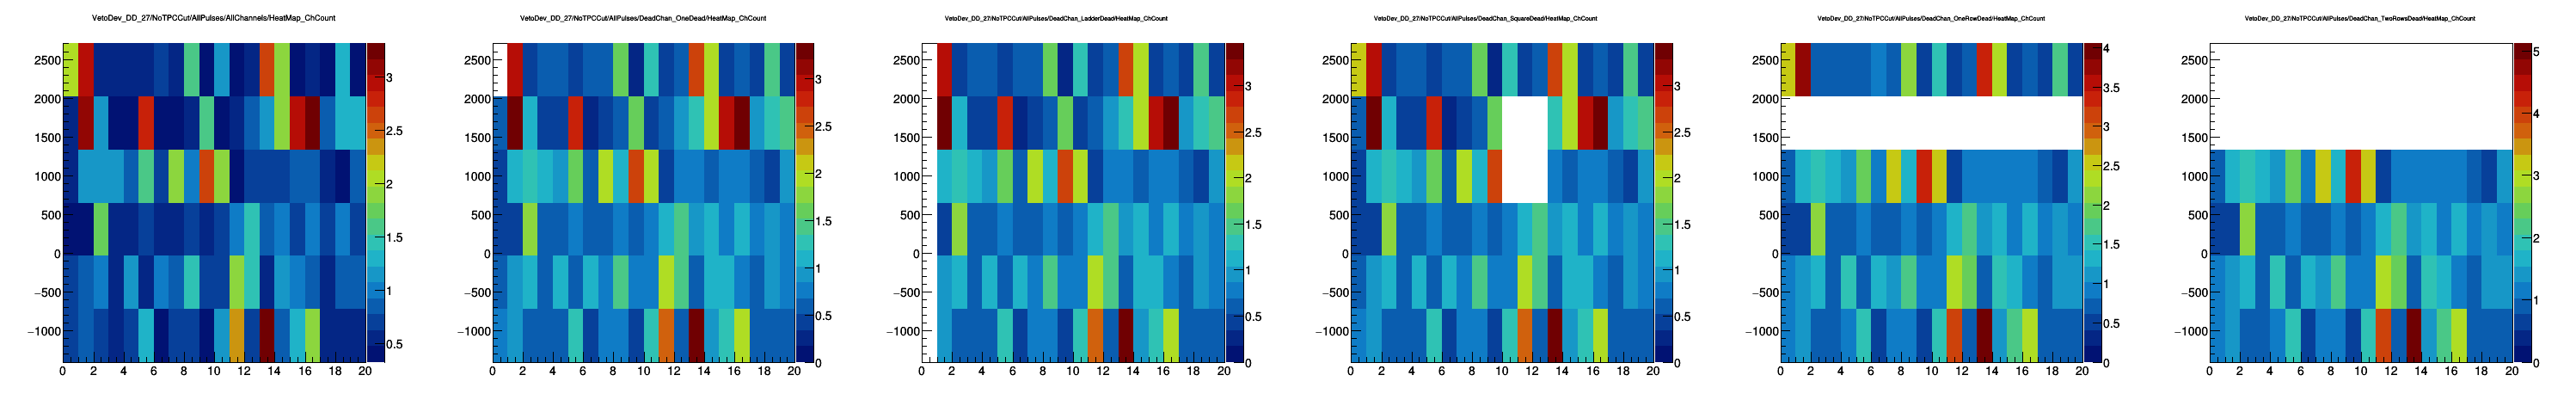

In [15]:
hist = 'HeatMap_ChCount'
histList = [s + hist for s in noECutAllPulses]

c = setupCanvas([fileloc] * len(histList), histList, ncols=6, norm=True, scales=[[],[],[]], normconst = 120)
c.Draw()
c.SaveAs('figs/DD_NoTPCCut_WhatsDead.png')

### Pulse Area

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_PulseArea.png has been created


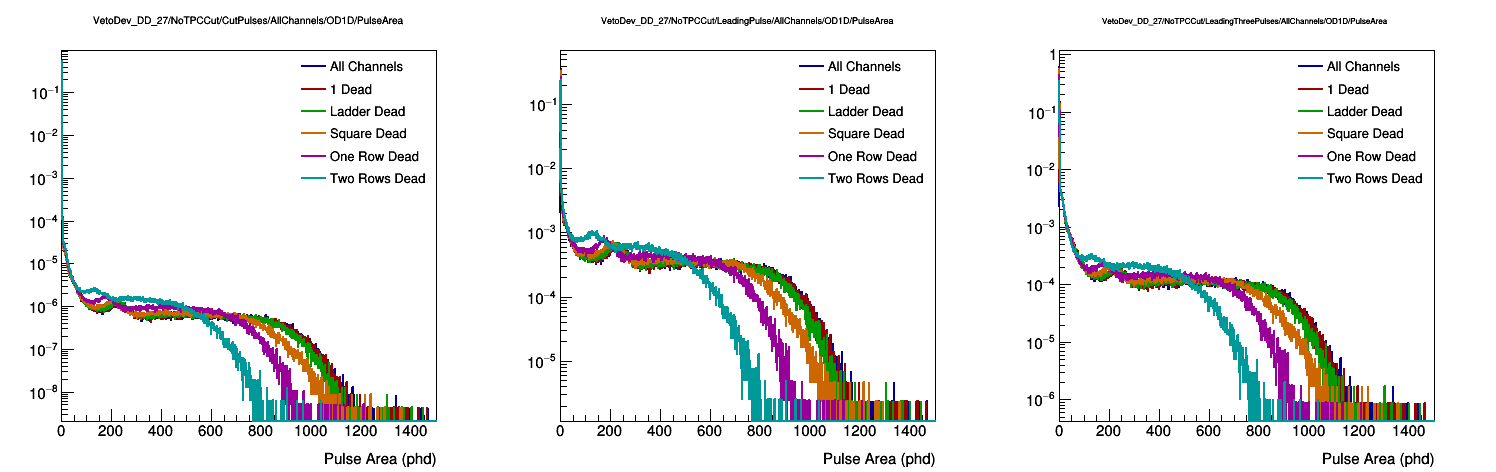

In [14]:
hist = 'OD1D/PulseArea'
histList = [s + hist for s in noECutCutPulses]
histList.extend([s + hist for s in noECutsLeadingPulse])
histList.extend([s + hist for s in noECutsLeadingThreePulses])

legendname = ['All Channels', '1 Dead', 'Ladder Dead', 'Square Dead', 'One Row Dead', 'Two Rows Dead']

c = setupCanvas([fileloc] * 40, histList, ncols=3, nOnCanvas=6,
                norm=True, normconst=1, logs=[False, True, False],
                scales=[[],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*3)
c.Draw()
c.SaveAs('figs/DD_NoTPCCut_PulseArea.png')

Comparison between OD Leading, Three Leading and all cut pulses

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_PulseArea_PMT_comparison.png has been created


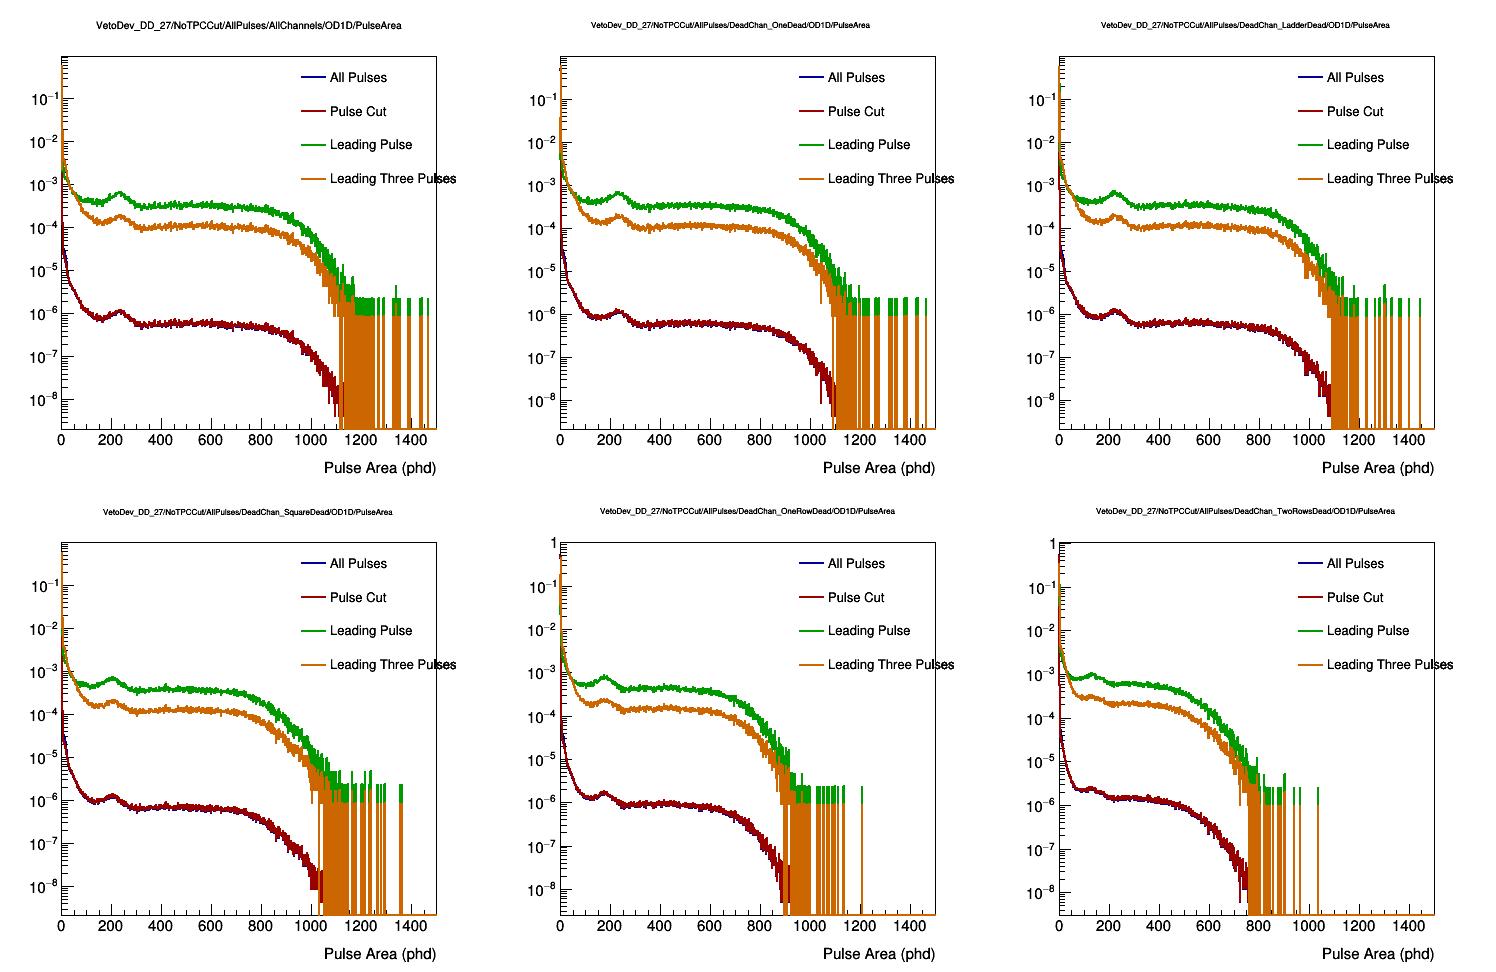

In [50]:
hist = 'OD1D/PulseArea'
histList = []
for i in range(len(noECutCutPulses)):
    histList.extend([noECutAllPulses[i]])
    histList.extend([noECutCutPulses[i]])
    histList.extend([noECutsLeadingPulse[i]])
    histList.extend([noECutsLeadingThreePulses[i]])
histList = [s + hist for s in histList]

legendname = ['All Pulses', 'Pulse Cut','Leading Pulse', 'Leading Three Pulses'] * 12

c = setupCanvas([fileloc] * 40, histList, ncols=3, nOnCanvas=4,
                norm=True, normconst=1, logs=[False, True, False],
                scales=[[],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*3)
c.Draw()
c.SaveAs('figs/DD_PulseArea_PMT_comparison.png')

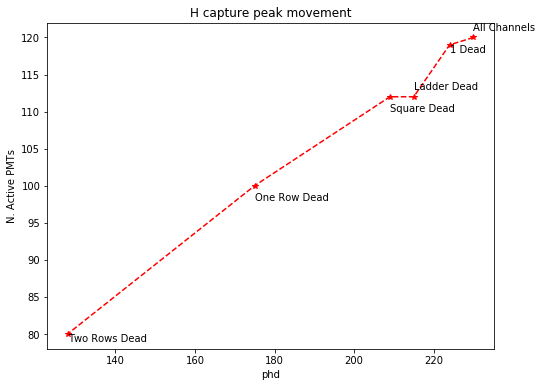

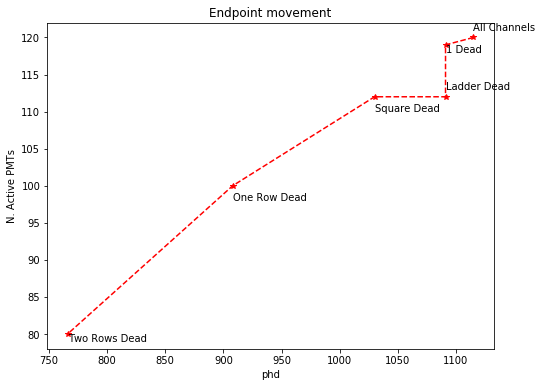

In [40]:
import uproot
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
def calculateLinearity(fileloc, name,width):
    """TODO: Do in root instead
    """
    H_capture_phd = []
    end_point_phd = []

    for n in name:
        a = uproot.open(fileloc)[n]
        b = a.values
        b = b / b.sum() # normalise
        peaks, _ = find_peaks(b, width=width)
        # max peak will be H-capture in counts
        H_capture_phd.append(peaks[b[peaks].argmax()])
        end_point_phd.append(b[1:].argmin()) # first phd where no counts
    return H_capture_phd, end_point_phd

hist = 'OD1D/PulseArea'
# Leading Pulse
histList = [s + hist for s in noECutsLeadingPulse]
H_phd_leading, Gd_endpoint_leading = calculateLinearity(fileloc, histList, width=11)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
n_pmts = [120, 119, 112, 112, 100, 80]
ax.plot(H_phd_leading, n_pmts, 'r*--', label='Leading Pulse')
leg=['All Channels', '1 Dead', 'Ladder Dead', 'Square Dead', 'One Row Dead', 'Two Rows Dead']
i=0
ypos = [121, 118, 113, 110, 98, 79]
for i, name in enumerate(leg):                                       
    x = H_phd_leading[i]
    y = n_pmts[i]
    ax.annotate(name, (x,ypos[i]))
    i+=1
ax.set_xlabel('phd')
ax.set_ylabel('N. Active PMTs')
ax.set_title('H capture peak movement')
plt.show()
# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
n_pmts = [120, 119, 112, 112, 100, 80]
ax.plot(Gd_endpoint_leading, n_pmts, 'r*--', label='Leading Pulse')
i=0
ypos = [121, 118, 113, 110, 98, 79]
for i, name in enumerate(leg):                                       
    x = Gd_endpoint_leading[i]
    y = n_pmts[i]
    ax.annotate(name, (x,ypos[i]))
    i+=1
ax.set_xlabel('phd')
ax.set_ylabel('N. Active PMTs')
ax.set_title('Endpoint movement')
plt.show()

### Coincidence

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_NoTPCCut_Coincidence.png has been created


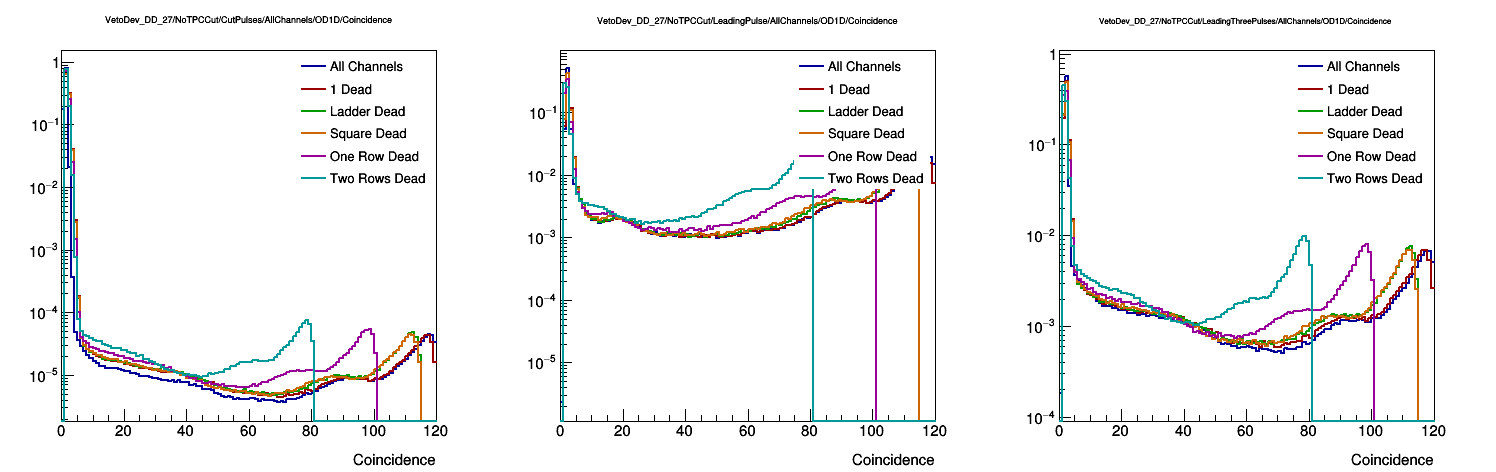

In [19]:
hist = 'OD1D/Coincidence'
histList = [s + hist for s in noECutCutPulses]
histList.extend([s + hist for s in noECutsLeadingPulse])
histList.extend([s + hist for s in noECutsLeadingThreePulses])

legendname = ['All Channels', '1 Dead', 'Ladder Dead', 'Square Dead', 'One Row Dead', 'Two Rows Dead']

c = setupCanvas([fileloc] * 40, histList, ncols=3, nOnCanvas=6,
                norm=True, normconst=1, logs=[False, True, False],
                scales=[[],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*3)
c.Draw()
c.SaveAs('figs/DD_NoTPCCut_Coincidence.png')

### PHD / Coincidence

In [53]:
hist = 'OD2D/Coincidence_Over_PulseArea'
#histList = [s + hist for s in noECutCutPulses]
histList = ([s + hist for s in noECutsLeadingPulse])
#histList.extend([s + hist for s in noECutsLeadingThreePulses])

c = setupCanvas([fileloc] * 40, histList, ncols=3, nOnCanvas=1,
                norm=False, normconst=1, logs=[False, False, True],
                scales=[[],[],[]], drawtype='colz')
c.Draw()
c.SaveAs('figs/DD_phdvsCoincidence.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_phdvsCoincidence.png has been created


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


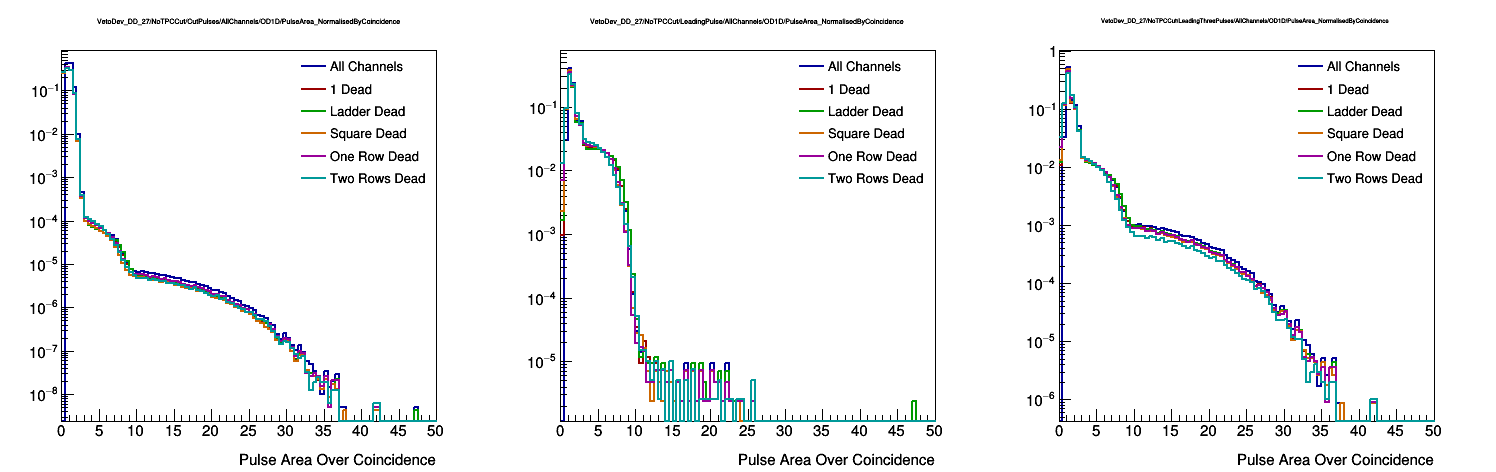

In [21]:
hist = 'OD1D/PulseArea_NormalisedByCoincidence'
histList = [s + hist for s in noECutCutPulses]
histList.extend([s + hist for s in noECutsLeadingPulse])
histList.extend([s + hist for s in noECutsLeadingThreePulses])

legendname = ['All Channels', '1 Dead', 'Ladder Dead', 'Square Dead', 'One Row Dead', 'Two Rows Dead']

c = setupCanvas([fileloc] * 40, histList, ncols=3, nOnCanvas=6,
                norm=True, normconst=1, logs=[False, True, False],
                scales=[[0,50],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*3)
c.Draw()

## MDC3 Cuts

In [36]:
histList = ["PulseSelection_Efficiency_NEvents_AllPulses",
           "PulseSelection_Efficiency_NEvents_CutPulses",
           "PulseSelection_Efficiency_NEvents_LeadingPulse",
           "PulseSelection_Efficiency_NEvents_ThreeLeadingPulses"]
c = setupCanvas([fileloc] * 90, histList, ncols=2, nOnCanvas=1,
                norm=False, normconst=1, logs=[False, True, False],
                scales=[[],[],[]], drawtype='histo')
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [101]:
cut = 'MDC3Cuts/Cut0_SS'
Cut0_SS_AllPulses = createHistList(cut, 'AllPulses')
Cut0_SS_CutPulses = createHistList(cut, 'CutPulses')
Cut0_SS_LeadingPulse = createHistList(cut, 'LeadingPulse')
Cut0_SS_LeadingThreePulses = createHistList(cut, 'LeadingThreePulses')

cut = 'MDC3Cuts/Cut1_ROI'
Cut1_ROI_AllPulses = createHistList(cut, 'AllPulses')
Cut1_ROI_CutPulses = createHistList(cut, 'CutPulses')
Cut1_ROI_LeadingPulse = createHistList(cut, 'LeadingPulse')
Cut1_ROI_LeadingThreePulses = createHistList(cut, 'LeadingThreePulses')

cut = 'MDC3Cuts/Cut2_FID'
Cut2_FID_AllPulses = createHistList(cut, 'AllPulses')
Cut2_FID_CutPulses = createHistList(cut, 'CutPulses')
Cut2_FID_LeadingPulse = createHistList(cut, 'LeadingPulse')
Cut2_FID_LeadingThreePulses = createHistList(cut, 'LeadingThreePulses')

cut = 'MDC3Cuts/Cut3_Skin'
Cut3_Skin_AllPulses = createHistList(cut, 'AllPulses')
Cut3_Skin_CutPulses = createHistList(cut, 'CutPulses')
Cut3_Skin_LeadingPulse = createHistList(cut, 'LeadingPulse')
Cut3_Skin_ThreeThreePulses = createHistList(cut, 'LeadingThreePulses')

### Pulse Area

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


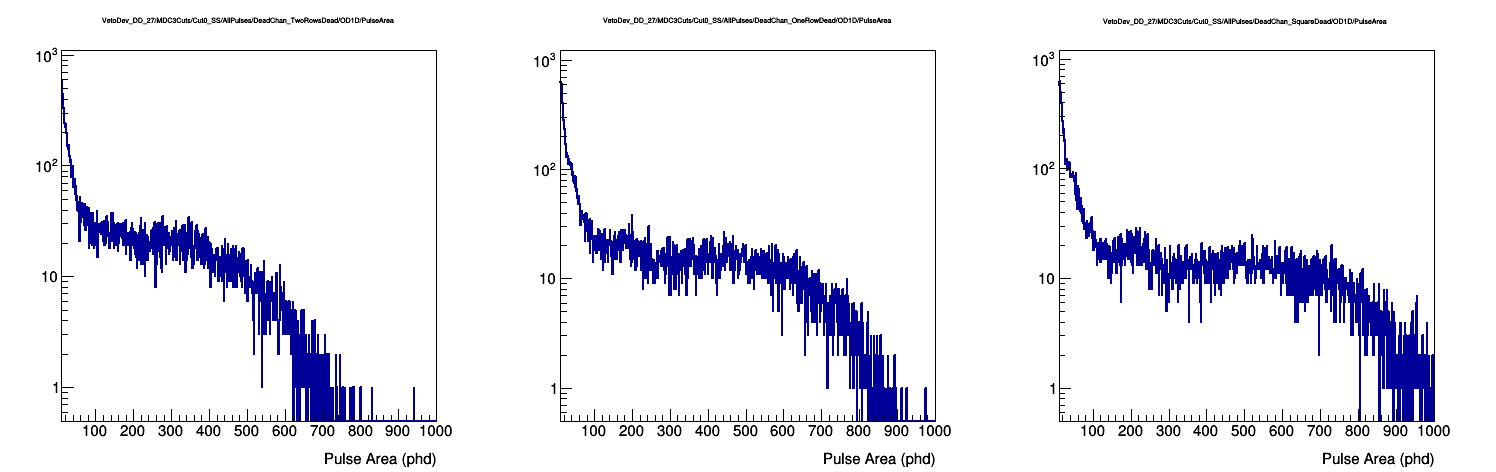

In [59]:
hist = 'OD1D/PulseArea'
histList= [s + hist for s in reversed(Cut0_SS_AllPulses)][:3]

legendname = ['Square Dead', 'One Row Dead', 'Two Rows Dead']

c = setupCanvas([fileloc] * 90, histList, ncols=3, nOnCanvas=1,
                norm=False, normconst=1, logs=[False, True, False],
                scales=[[10,1000],[],[]], drawtype='histo')
                #haslegend=True, legendname=legendname*22)
c.Draw()
#c.SaveAs('figs/DD_SS_PulseArea.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_SS_PulseArea.png has been created


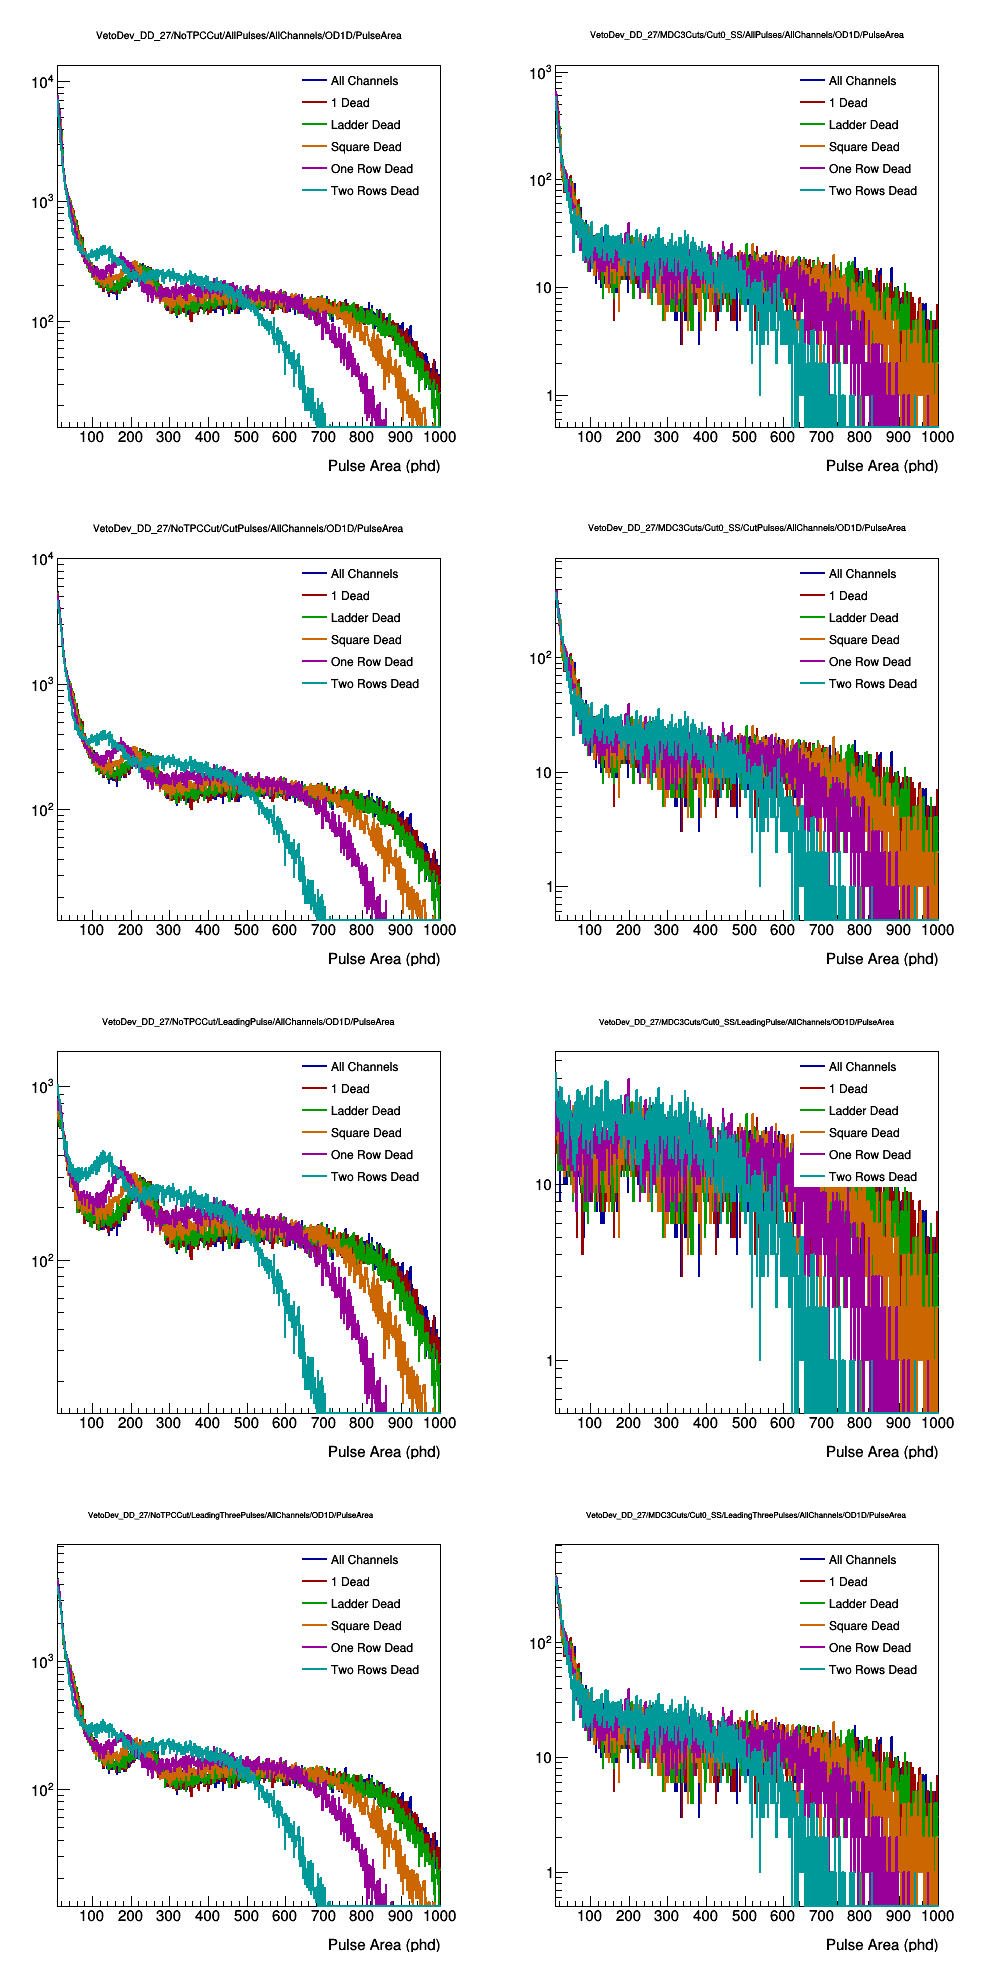

In [54]:
hist = 'OD1D/PulseArea'
histList = [s + hist for s in noECutAllPulses]
histList.extend([s + hist for s in Cut0_SS_AllPulses])

histList.extend([s + hist for s in noECutCutPulses])
histList.extend([s + hist for s in Cut0_SS_CutPulses])

histList.extend([s + hist for s in noECutsLeadingPulse])
histList.extend([s + hist for s in Cut0_SS_LeadingPulse])

histList.extend([s + hist for s in noECutsLeadingThreePulses])
histList.extend([s + hist for s in Cut0_SS_LeadingThreePulses])

legendname = ['All Channels', '1 Dead', 'Ladder Dead', 'Square Dead', 'One Row Dead', 'Two Rows Dead']

c = setupCanvas([fileloc] * 90, histList, ncols=2, nOnCanvas=6,
                norm=False, normconst=1, logs=[False, True, False],
                scales=[[10,1000],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*22)
c.Draw()
c.SaveAs('figs/DD_SS_PulseArea.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_SS_PulseArea_R.png has been created


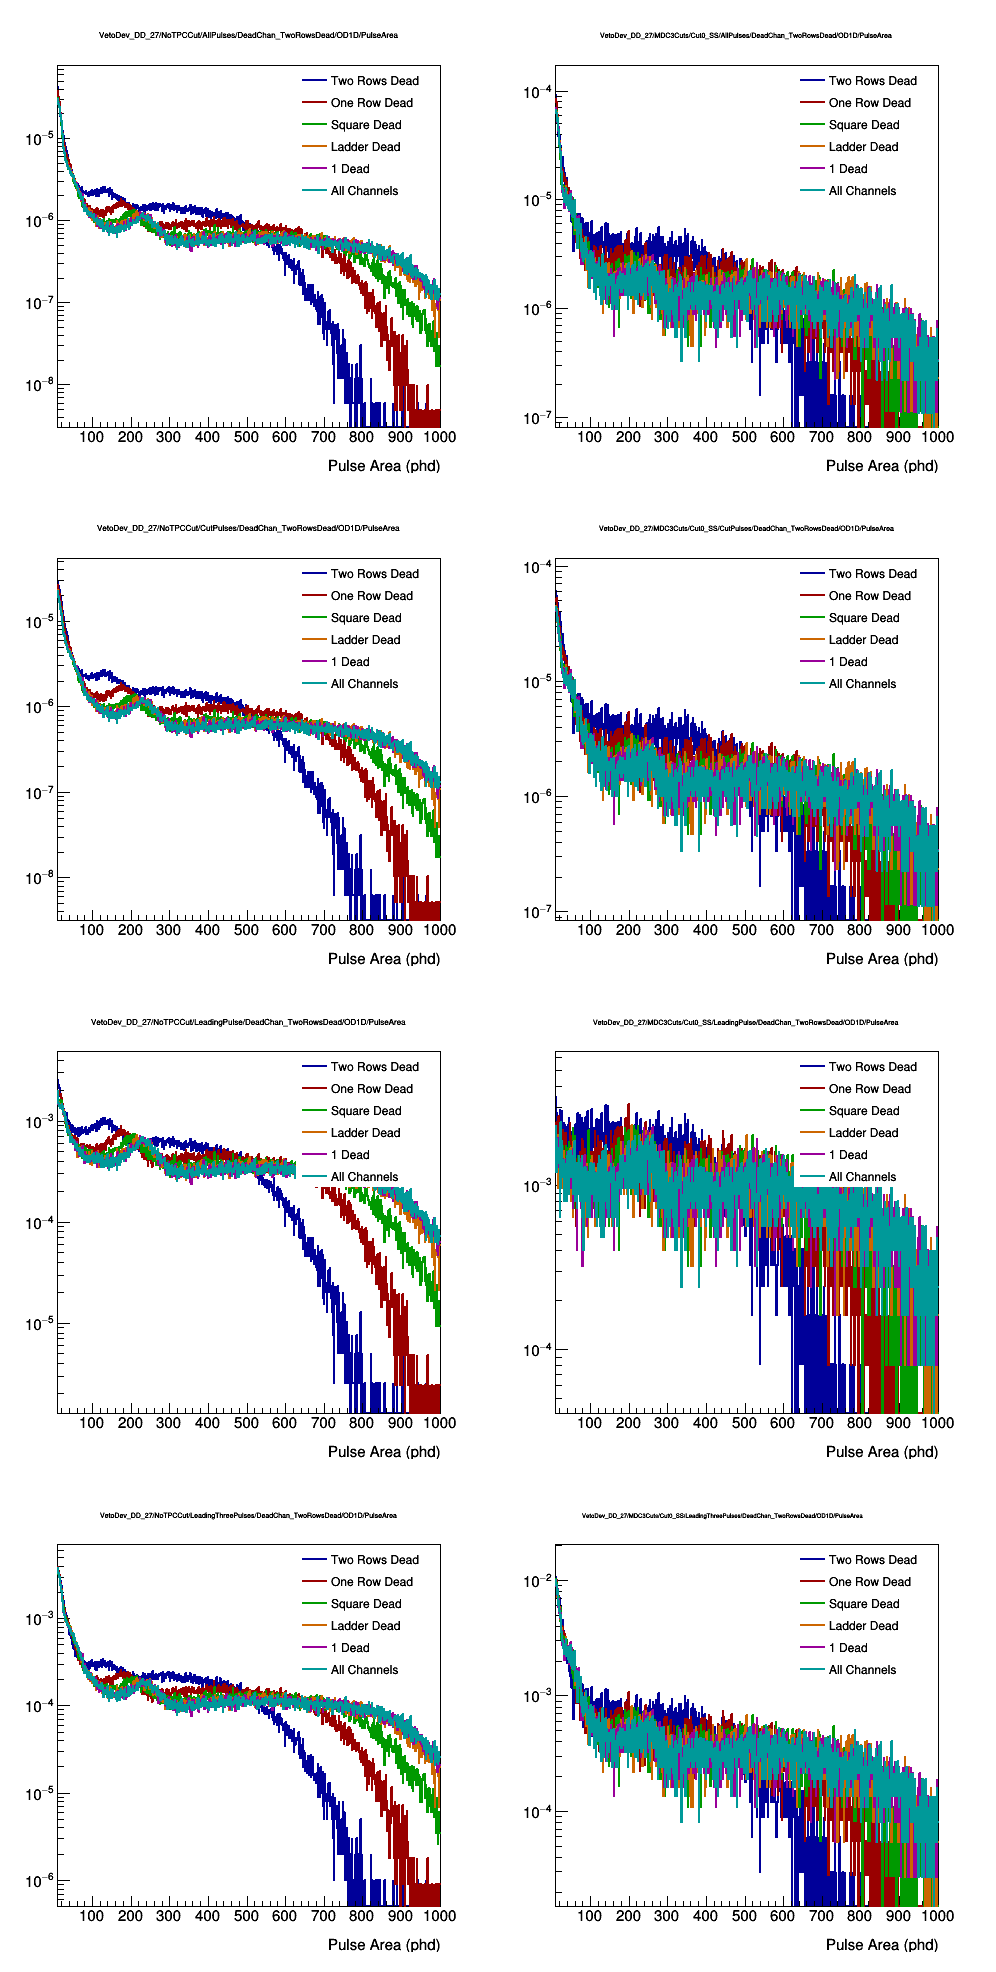

In [55]:
hist = 'OD1D/PulseArea'
histList = [s + hist for s in reversed(noECutAllPulses)]
histList.extend([s + hist for s in reversed(Cut0_SS_AllPulses)])

histList.extend([s + hist for s in reversed(noECutCutPulses)])
histList.extend([s + hist for s in reversed(Cut0_SS_CutPulses)])

histList.extend([s + hist for s in reversed(noECutsLeadingPulse)])
histList.extend([s + hist for s in reversed(Cut0_SS_LeadingPulse)])

histList.extend([s + hist for s in reversed(noECutsLeadingThreePulses)])
histList.extend([s + hist for s in reversed(Cut0_SS_LeadingThreePulses)])

legendname = list(reversed(['All Channels', '1 Dead', 'Ladder Dead', 'Square Dead', 'One Row Dead', 'Two Rows Dead']))
c = setupCanvas([fileloc] * 90, histList, ncols=2, nOnCanvas=6,
                norm=True, normconst=1, logs=[False, True, False],
                scales=[[10,1000],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*22)
c.Draw()
c.SaveAs('figs/DD_SS_PulseArea_R.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_SS_PulseArea_single.png has been created


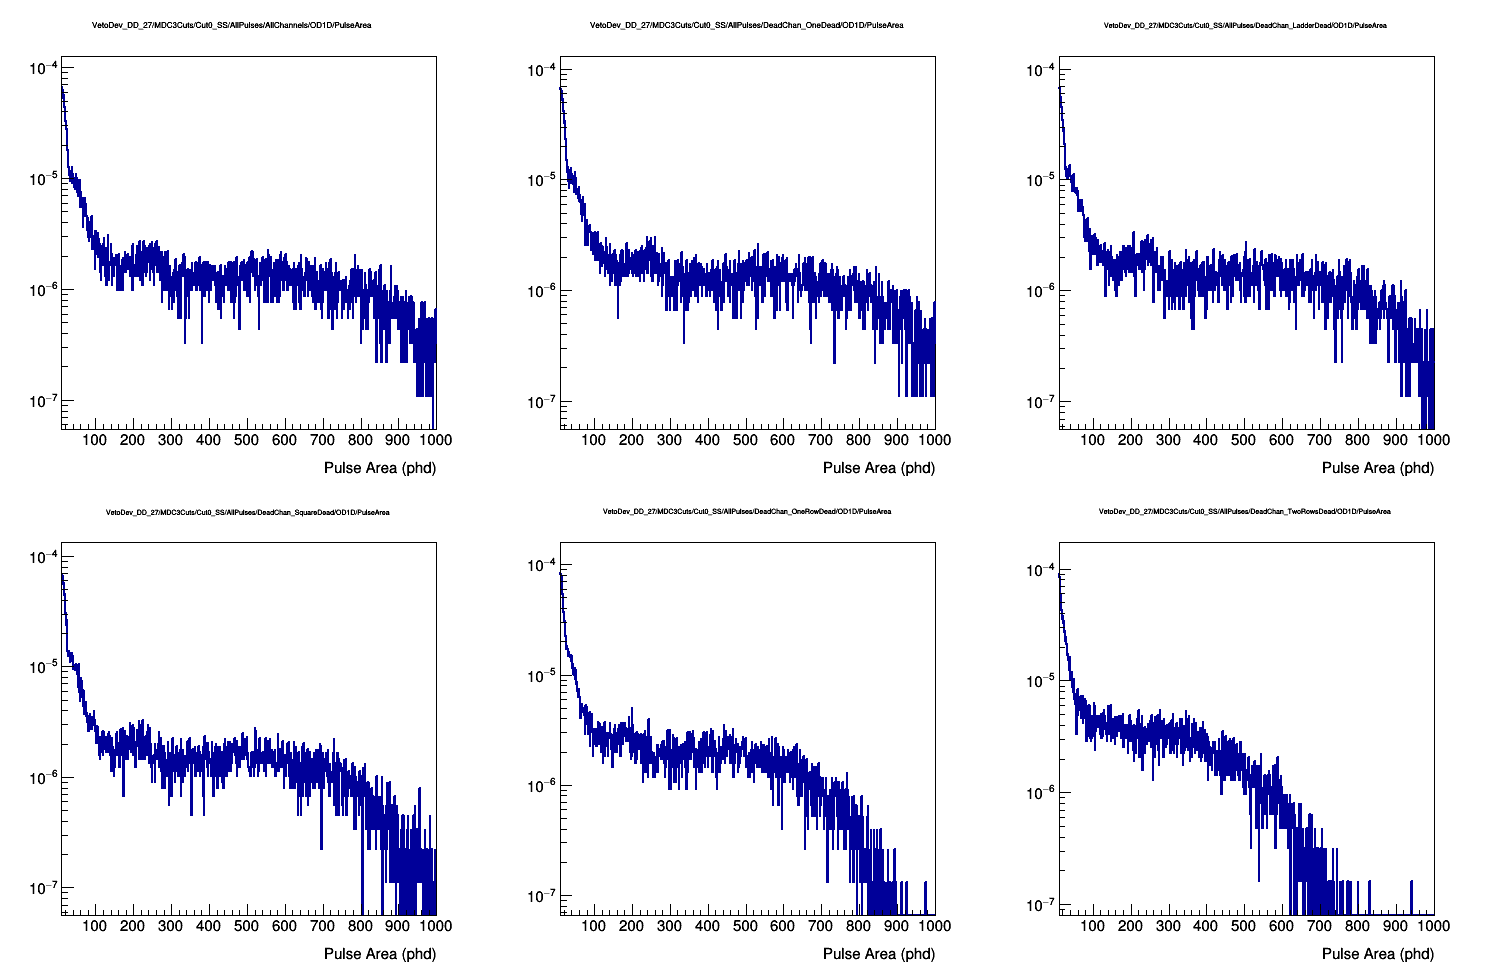

In [60]:
hist = 'OD1D/PulseArea'
histList = ([s + hist for s in (Cut0_SS_AllPulses)])

c = setupCanvas([fileloc] * 90, histList, ncols=3, nOnCanvas=1,
                norm=True, normconst=1, logs=[False, True, False],
                scales=[[10,1000],[],[]], drawtype='histo')
c.Draw()
c.SaveAs('figs/DD_SS_PulseArea_single.png')

hists

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_SS_CoincidenceVsTimeDiff.png has been created


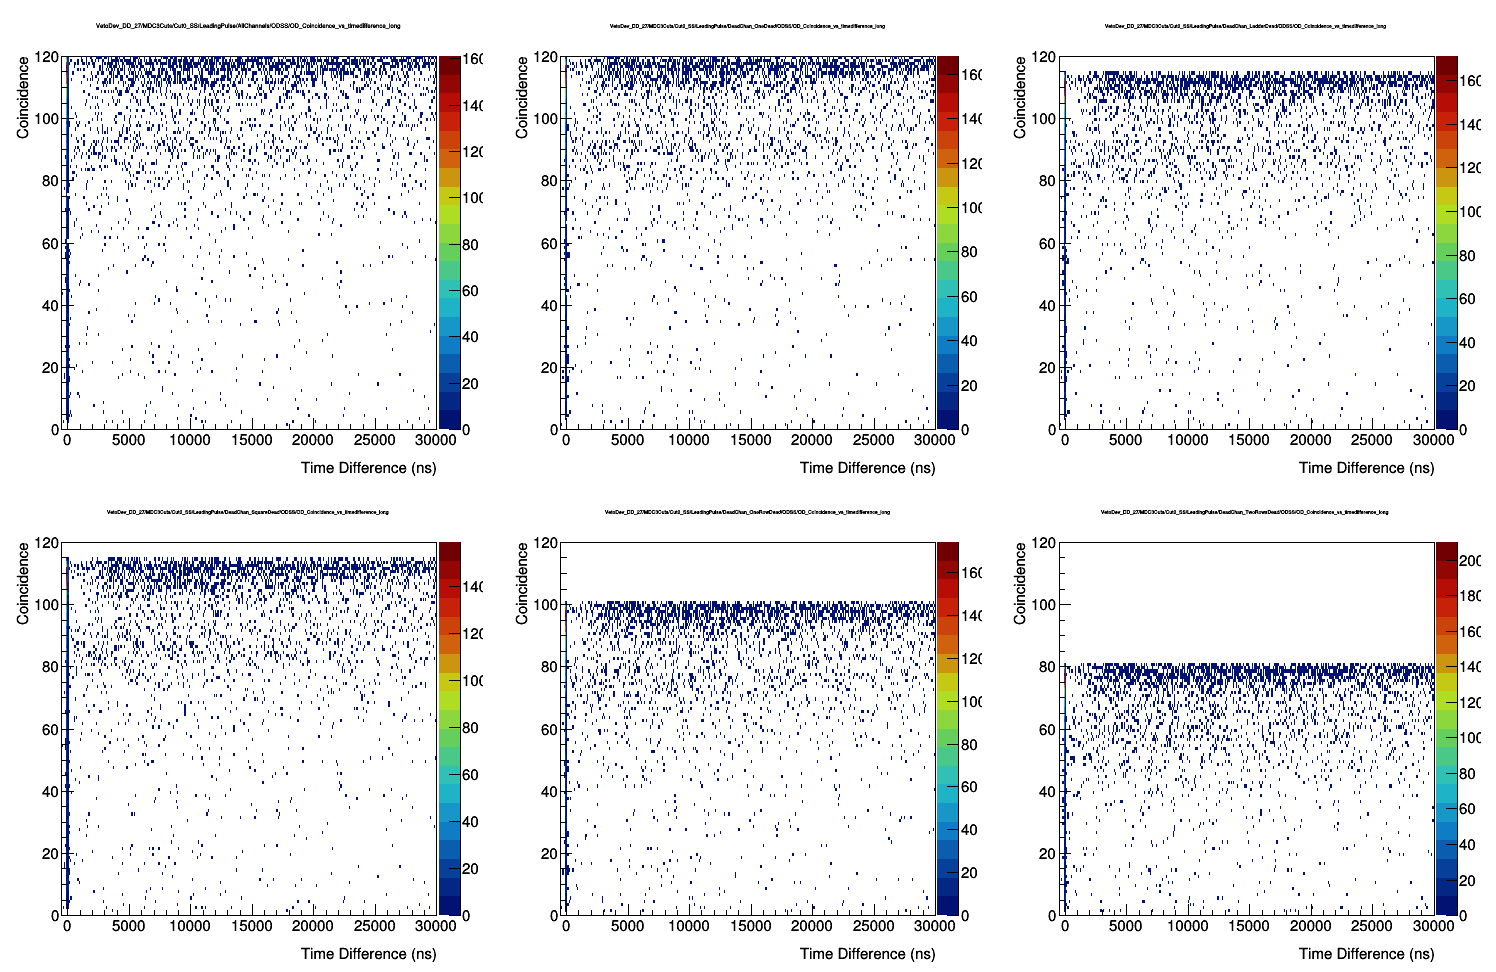

In [139]:
hist = 'ODSS/OD_Coincidence_vs_timedifference_long'
#histList = ([s + hist for s in Cut0_SS_AllPulses])
#histList = [s + hist for s in Cut0_SS_CutPulses] 
histList = [s + hist for s in Cut0_SS_LeadingPulse]
#histList = [s + hist for s in Cut0_SS_LeadingThreePulses]

c = setupCanvas([fileloc] * 40, histList, ncols=3, nOnCanvas=1,
                norm=False, normconst=1, logs=[False, False, False],
                scales=[[-500,30000],[],[]], drawtype='colz')
c.Draw()
c.SaveAs('figs/DD_SS_CoincidenceVsTimeDiff.png')

In [98]:
hist = 'OD1D/PulseArea'
histList = [s + hist for s in Cut0_SS_AllPulses]
histList.extend([s + hist for s in Cut1_ROI_AllPulses])
histList.extend([s + hist for s in Cut2_FID_AllPulses])
histList.extend([s + hist for s in Cut3CutAllPulses])

legendname = ['All Channels', '1 Dead', 'Ladder Dead', 'Square Dead', 'One Row Dead', 'Two Rows Dead']

c = setupCanvas([fileloc] * 90, histList, ncols=2, nOnCanvas=6,
                norm=True, normconst=1, logs=[False, True, False],
                scales=[[],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*22)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [33]:
hist = 'OD1D/PulseArea'
histList = [s + hist for s in reversed(Cut0_SS_AllPulses)]
histList.extend([s + hist for s in reversed(Cut1_ROI_AllPulses)])
histList.extend([s + hist for s in reversed(Cut2_FID_AllPulses)])
histList.extend([s + hist for s in reversed(Cut3CutAllPulses)])

legendname = list(reversed(['All Channels', '1 Dead', 'Ladder Dead', 'Square Dead', 'One Row Dead', 'Two Rows Dead']))

c = setupCanvas([fileloc] * 90, histList, ncols=2, nOnCanvas=6,
                norm=True, normconst=1, logs=[False, True, False],
                scales=[[],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*22)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figs/DD_PulseArea_PMT_and_Cut_comparison.png has been created


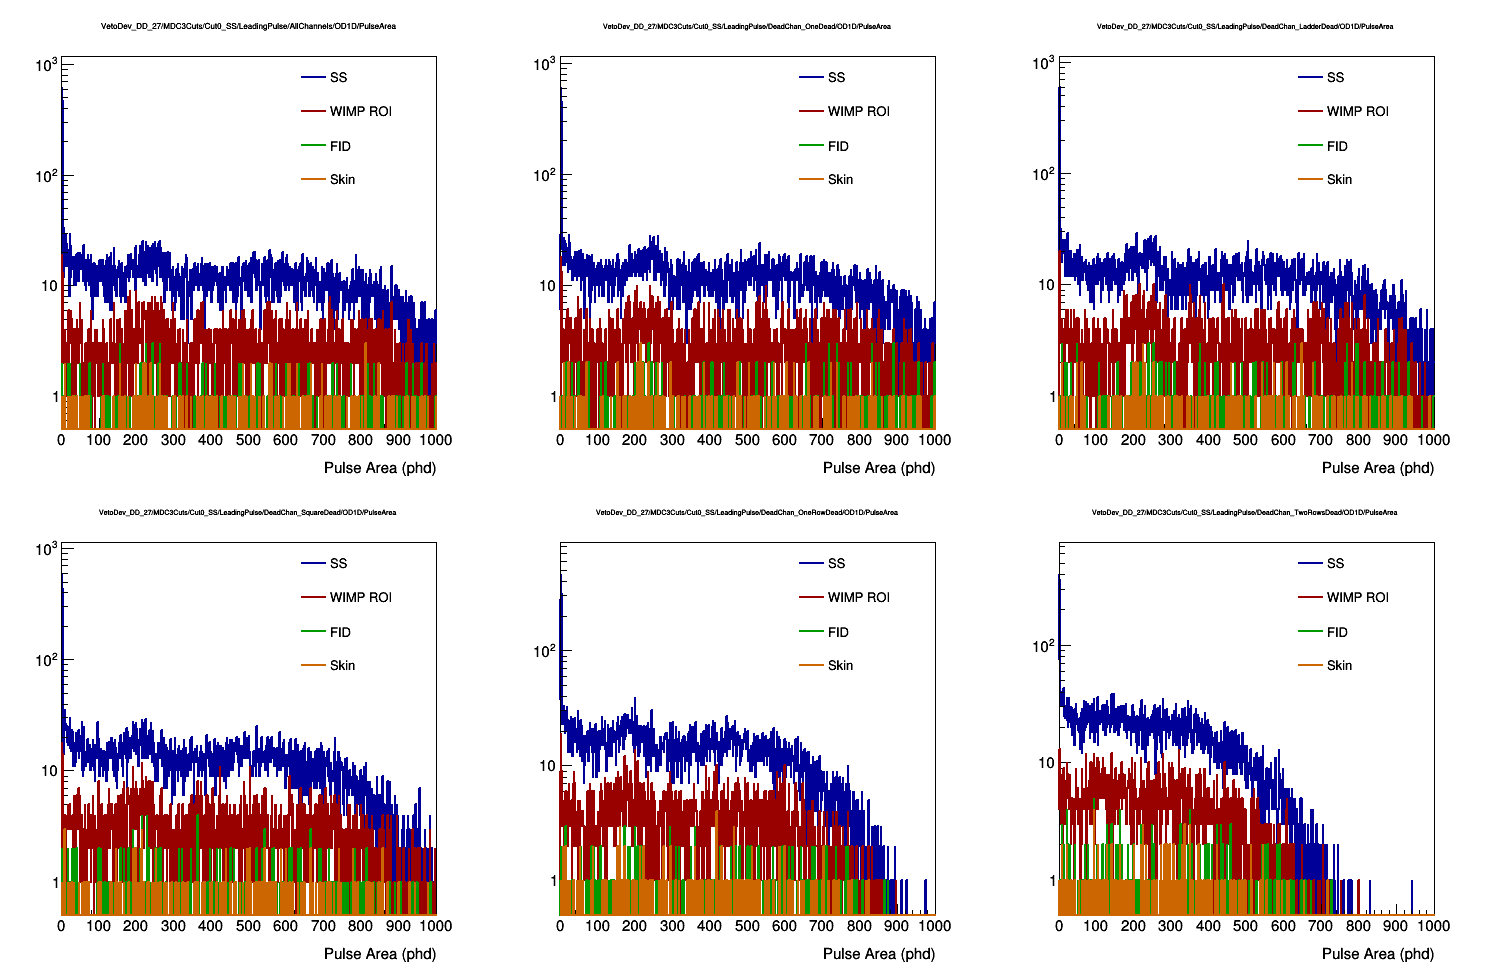

In [125]:
hist = 'OD1D/PulseArea'
histList = []
for i in range(len(Cut0_SS_AllPulses)):
    histList.extend([Cut0_SS_LeadingPulse[i]])
    histList.extend([Cut1_ROI_LeadingPulse[i]])
    histList.extend([Cut2_FID_LeadingPulse[i]])
    histList.extend([Cut3_Skin_LeadingPulse[i]])
histList = [s + hist for s in histList]

legendname = ['SS', 'WIMP ROI','FID', 'Skin'] * 12

c = setupCanvas([fileloc] * 40, histList, ncols=3, nOnCanvas=4,
                norm=False, normconst=1, logs=[False, True, False],
                scales=[[0,1000],[],[]], drawtype='histo',
                haslegend=True, legendname=legendname*3)
c.Draw()
c.SaveAs('figs/DD_PulseArea_PMT_and_Cut_comparison.png')